In [1]:
import torch
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from ipynb.fs.full.base_model import AttentionModule, embeddings, ModelArchitecture
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F



In [2]:
a = torch.tensor(np.arange(0,113))
b = a
e = torch.ones(12769)*113
e = e.unsqueeze(1)
X = torch.concatenate([torch.cartesian_prod(a, b), e],1)
X = X.long()

In [3]:
dataset_y = (X[:, 0] + X[:,1])%113
y = dataset_y

In [4]:
attention = AttentionModule()
embedding = embeddings()
model_low = ModelArchitecture(n = 512, d_k = 128, attention = attention, embedding = embedding)
model_high = ModelArchitecture(n = 512, d_k = 128, attention = attention, embedding = embedding)
model_weights_low = torch.load("model_weights/19600_weights_prec_low_loss.pt")
model_weights_high = torch.load('model_weights/20000_weights_high_loss.pt')
model_low.load_state_dict(model_weights_low)
model_high.load_state_dict(model_weights_high)

model_low.eval()
model_high.eval()

ModelArchitecture(
  (attention): AttentionModule()
  (embedding): embeddings(
    (token_emb): Embedding(114, 128)
  )
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
  )
  (unembed): Linear(in_features=128, out_features=114, bias=False)
)

In [5]:
print(model_weights_low.keys())

odict_keys(['attention.query_v1', 'attention.key_v1', 'attention.value_v1', 'attention.query_v2', 'attention.key_v2', 'attention.value_v2', 'attention.query_v3', 'attention.key_v3', 'attention.value_v3', 'attention.query_v4', 'attention.key_v4', 'attention.value_v4', 'embedding.token_emb.weight', 'mlp.0.weight', 'mlp.0.bias', 'mlp.2.weight', 'mlp.2.bias', 'unembed.weight'])


In [6]:
activations_low = {}
activations_high = {}


def hook_fn_low(module, input, output):
    activations_low['mlp_2'] = output.detach()

def hook_fn_high(module, input, output):
    activations_high['mlp_2'] = output.detach()

handle_low = model_low.mlp[2].register_forward_hook(hook_fn_low)
handle_high = model_high.mlp[2].register_forward_hook(hook_fn_high)


In [7]:
X = X.unsqueeze(0)

In [10]:
X.shape
X[:, 1, :]

tensor([[  0,   1, 113]])

In [41]:
cosines = []
h_low = []
h_high = []
sum_high = []
sum_low = []
for i in range(X.shape[1]):
    x = X[:, i, :]
    _, logit_low = model_low(x)
    _, logit_high = model_high(x)
    mean_low = torch.mean(logit_low)
    mean_high = torch.mean(logit_high)
    sum_high.append(mean_high.item())
    sum_low.append(mean_low.item())
    v_low = activations_low['mlp_2'].squeeze(0)[2]
    h_low.append(v_low)
    v_high = activations_high['mlp_2'].squeeze(0)[2]
    h_high.append(v_high)


    #v_norm_low = v_low / v_low.norm(p=2)
    #v_norm_high = v_high / v_high.norm(p=2)
    #cos_sim = F.cosine_similarity(v_norm_low, v_norm_high, dim=0)
    #cosines.append(cos_sim)

In [38]:
h_low_t = torch.stack(h_low)
h_high_t = torch.stack(h_high)
#h_low_t.shape


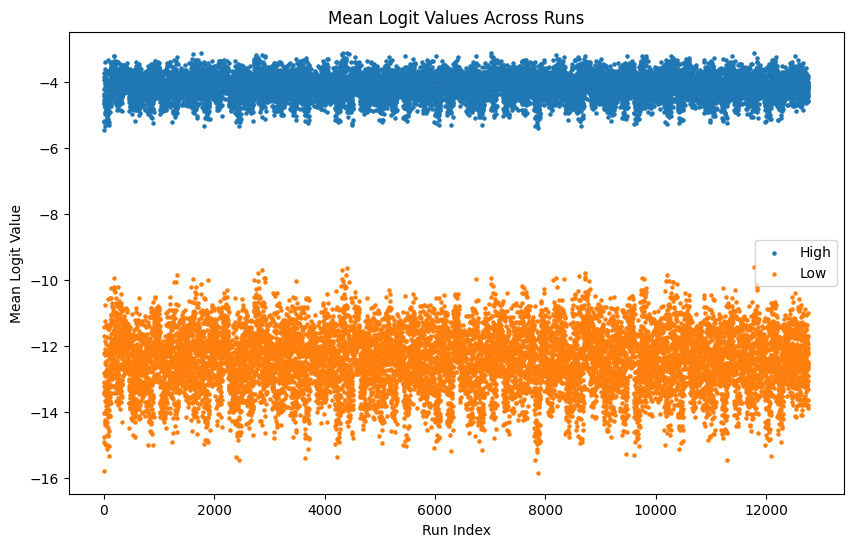

In [45]:

arr1 = np.array(sum_high)
arr2 = np.array(sum_low)

# X-axis = run index
x = np.arange(len(arr1))

plt.figure(figsize=(10, 6))

plt.scatter(x, arr1, s=5, label="High")
plt.scatter(x, arr2, s=5, label="Low")

plt.xlabel("Run Index")
plt.ylabel("Mean Logit Value")
plt.title("Mean Logit Values Across Runs")
plt.legend()

plt.show()


# PCA Analysis

In [25]:
H_post_centered = h_low_t - h_low_t.mean(dim=0, keepdim=True)
H_spike_centered = h_high_t - h_high_t.mean(dim=0, keepdim=True)
U_post, S_post, Vh_post = torch.linalg.svd(H_post_centered, full_matrices=False)
U_spike, S_spike, Vh_spike = torch.linalg.svd(H_spike_centered, full_matrices=False)


In [26]:
k = 10

V_post_k = Vh_post[:k, :]
V_spike_k = Vh_spike[:k, :]
V_post_k = V_post_k.T
V_spike_k = V_spike_k.T


In [27]:
M = V_post_k.T @ V_spike_k

_, S_overlap, _ = torch.linalg.svd(M)

In [28]:
print("Principal angle cosines:", S_overlap)
print("Mean overlap:", S_overlap.mean().item())

Principal angle cosines: tensor([0.9990, 0.9988, 0.9975, 0.9961, 0.9952, 0.9942, 0.9934, 0.9905, 0.9389,
        0.3420])
Mean overlap: 0.9245615005493164


In [29]:
print("Singular values (post):")
print(S_post[:20])

print("Singular values (spike):")
print(S_spike[:20])


Singular values (post):
tensor([1932.8748, 1447.3070, 1293.6542, 1216.0962, 1061.3794,  955.5098,
         843.6375,  826.8291,  474.4514,  272.6667,  254.3630,  234.1277,
         196.9609,  148.8082,  147.0643,  128.9039,  106.7284,   67.3316,
          48.7390,   22.1604])
Singular values (spike):
tensor([1073.9905,  910.6240,  789.0483,  763.3068,  711.1629,  663.4995,
         534.9416,  499.0480,  227.6033,  177.5326,  159.5543,  147.6780,
         135.8651,  118.2674,  111.9925,   96.5105,   69.3171,   57.5130,
          31.7769,   21.3860])


# Cosine Similarity

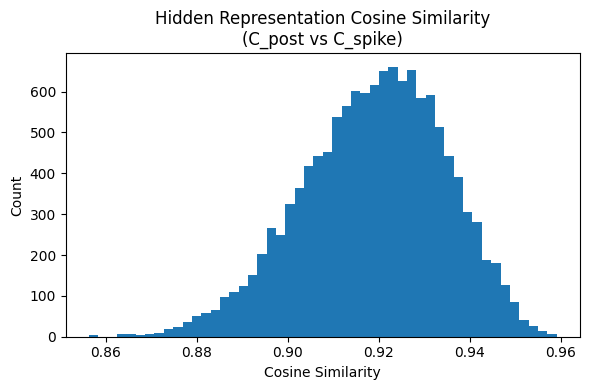

In [15]:

cosines_np = np.array(cosines)

plt.figure(figsize=(6, 4))
plt.hist(cosines_np, bins=50)
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.title("Hidden Representation Cosine Similarity\n(C_post vs C_spike)")
plt.tight_layout()
plt.show()


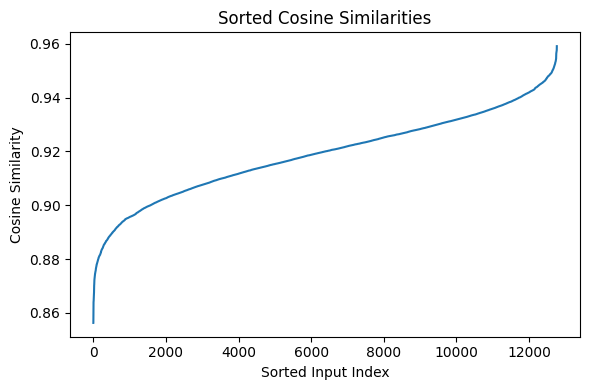

In [17]:
sorted_cos = np.sort(cosines_np)

plt.figure(figsize=(6, 4))
plt.plot(sorted_cos)
plt.xlabel("Sorted Input Index")
plt.ylabel("Cosine Similarity")
plt.title("Sorted Cosine Similarities")
plt.tight_layout()
plt.show()


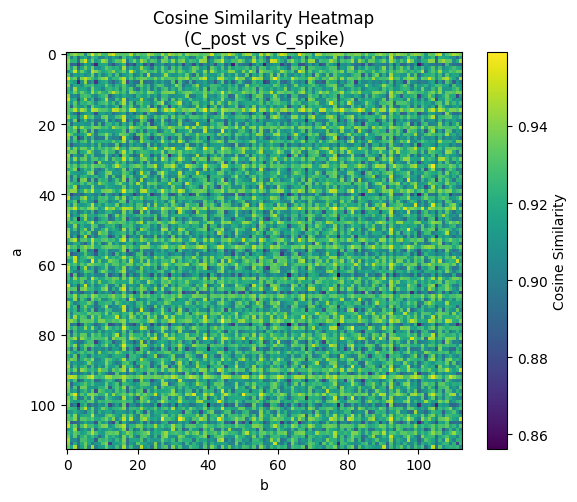

In [16]:
heatmap = cosines_np.reshape(113, 113)

plt.figure(figsize=(6, 5))
plt.imshow(heatmap)
plt.colorbar(label="Cosine Similarity")
plt.xlabel("b")
plt.ylabel("a")
plt.title("Cosine Similarity Heatmap\n(C_post vs C_spike)")
plt.tight_layout()
plt.show()
